In [1]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains import RetrievalQA
from langchain_community.llms import OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import score
import logging
import pickle
from ragatouille import RAGPretrainedModel

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [5]:
retrieval_strategy = "colbert"
model = "llama-2-13b-chat.Q4_K_M"

persist_directory = "./../embeddings"
index_root = "./../colbert_index/"
colbert_path = "./../colbertv2.0/"
index_path = "./../colbert_index/colbert/indexes/documents/"

In [3]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [4]:
class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        # self.responses["question"].append(llm_response["question"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        # self.responses["answer"].append(llm_response["answer"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses

    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Colbert Retriever

In [8]:
RAG = RAGPretrainedModel.from_index(index_path=index_path)

[Apr 01, 20:45:08] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [9]:
retriever = RAG.as_langchain_retriever(k=5)

## Quantized Model

In [10]:
# llm_open = LlamaCpp(
#     #model_path=f"./../models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
#     model_path=f"/Users/arnewman/.cache/lm-studio/models/TheBloke/Llama-2-13B-chat-GGUF/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
#     n_ctx=4096,  # 4096 for Llama, 32*1024 for Mistral
#     n_gpu_layers=50,
#     temperature=0.15,
#     top_p=1,
#     top_k=40,
#     repeat_penalty=1.1,
#     max_tokens=1024,
#     callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
#     stream=True,
# )

llm_open = OpenAI(
    openai_api_base="http://localhost:1234/v1",
    openai_api_key="hello",
    temperature=0.15,
    top_p=1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [11]:
from langchain_core.prompts import PromptTemplate

template = """
Use only the following pieces of context to answer the question at the end. 
Keep your answers concise and do not provide additional explanations or interpretations. 
If the answer cannot be deduced from the context, just say that you don't know the answer, don't try to make up an answer.

{context}

Question: {question}
Helpful Answer:
"""

In [12]:
qa_chain = RetrievalQA.from_chain_type(
    # qa_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
    chain_type_kwargs={
        "prompt": PromptTemplate(
            template=template, input_variables=["context", "question"]
        )
    },
)

In [ ]:
print(qa_chain.combine_documents_chain.llm_chain.prompt.template)

In [13]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)

/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...
Loading searcher for index documents for the first time... This may take a few seconds
[Apr 01, 20:46:23] #> Loading codec...
[Apr 01, 20:46:23] #> Loading IVF...
[Apr 01, 20:46:23] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[Apr 01, 20:46:23] #> Loading doclens...


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 950.66it/s]

[Apr 01, 20:46:23] #> Loading codes and residuals...



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 39.31it/s]

[Apr 01, 20:46:23] Loading filter_pids_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


[Apr 01, 20:46:23] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Which class involves time series analysis?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2029, 2465, 7336, 2051, 2186, 4106, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Syllabus SIADS 632: Data Mining II Course Overview And Prerequisites
2. Data Mining II (SIADS 632): Learning Outcomes
3. Data Science for Social Good (SIADS 688): Learning Outcomes
4. Causal Inference (SIADS 630): Course Schedule
5. Network Analysis (SIADS 652): Course Schedule


## Run the Model

In [14]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?
How many points is the comprehensive oral exam worth in SIADS 593?
What is the penalty for late submission in SIADS 630?
How do I get accommodations for a class?
What is a backpack?
When is the latest I can drop a course?
How do I get an override to take a class?
How do I take a leave of absence from the MADS program?
What are the prerequisites for Search and Recommender Systems?


In [15]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [16]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retrieval_strategy}_{model}_formatter.pickle", "wb") as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "wb") as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Syllabus SIADS 632: Data Mining II Course Overview And Prerequisites
2. Data Mining II (SIADS 632): Learning Outcomes
3. Data Science for Social Good (SIADS 688): Learning Outcomes
4. Causal Inference (SIADS 630): Course Schedule
5. Network Analysis (SIADS 652): Course Schedule


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Syllabus Course Overview And Prerequisites
3. SQL and Databases (SIADS 511): Course Outcomes
4. Database Architecture & Technology (SIADS 611): Instructor And Course Assistants
5. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for SIADS 688: Data Science for Social Good Course Overview and Prerequisites
2. Capstone (SIADS 699): Course Syllabus For SIADS 699 Course Overview and Prerequisites
3. Data Science Ethics (SIADS 503): I. Course Basics Course Overview And Prerequisites
4. Data Science for Social Good (SIADS 688): Academic Integrity/Code of Conduct
5. Communicating Data Science Results (SIADS 523): Course Syllabus SIADS 523: Communicating Data Science Results (Fall 2023) Course Overview And Prerequisites


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Course Schedule
2. Math Methods I (SIADS 502): Course Schedule
3. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties
4. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties
5. Math Methods II (SIADS 602): Quizzes, Assignments, And Late Penalties


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Milestone II (SIADS 696): Weekly Readings
2. Milestone I (SIADS 593): 4.0 Weekly Readings
3. Milestone II (SIADS 696): You Must Complete All Assignments And Assessments, Regardless Of Their Weighting In The Final Grade, To Get Credit For This Course.
4. Milestone II (SIADS 696): Please Try To Monitor The Slack Channels For The Course Regularly.
5. Milestone II (SIADS 696): Course Schedule


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Qualitative Inquiry for Data Scientists (SIADS 601): Learning Outcomes
2. Qualitative Inquiry for Data Scientists (SIADS 601): Course Overview And Prerequisites Overview
3. Qualitative Inquiry for Data Scientists (SIADS 601): Additional Optional Readings:
4. Qualitative Inquiry for Data Scientists (SIADS 601): Grading And Assignments Overview
5. Qualitative Inquiry for Data Scientists (SIADS 601): Instructional Material


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Required Textbook
2. Data Manipulation (SIADS 505): Textbook Link Provided Above Allows Free Usage Through The University Of Michigan Library. University Credentials Required. Learning Outcomes
3. Math Methods I (SIADS 502): Recommended Textbooks
4. Data Science Ethics (SIADS 503): Required Textbook
5. Visual Exploration of Data (SIADS 521): Required Textbook


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Required Textbook
2. Data Manipulation (SIADS 505): Textbook Link Provided Above Allows Free Usage Through The University Of Michigan Library. University Credentials Required. Learning Outcomes
3. Data Mining I (SIADS 532): Required Textbook
4. Visual Exploration of Data (SIADS 521): Required Textbook
5. Data Manipulation (SIADS 505): Course Syllabus Course Overview And Prerequisites


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 2
2. Unsupervised Learning (SIADS 543): Schedule: Week 2
3. Unsupervised Learning (SIADS 543): Schedule: Week 4
4. Unsupervised Learning (SIADS 543): Schedule: Week 1
5. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 4


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
2. n/a (n/a): Academics > Master of Applied Data Science (MADS) > Summary of Degree Requirements
3. n/a (n/a): Academics > Grades and Grading Policy
4. n/a (n/a): Course Planning > Q: What is the recommended number of credits students should take?
5. n/a (n/a): Academics > Independent Study


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. n/a (n/a): General Academic Advising > Q: How long do I have to complete the program?
2. n/a (n/a): Grades/Transcripts > Q: What is the process for requesting an incomplete?
3. n/a (n/a): Academics > Grades and Grading Policy > Grade of Incomplete (I)
4. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
5. n/a (n/a): Course Planning > Q: How are the MADS courses/semesters set up?


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Milestone I (SIADS 593): 7.0 Grading And Course Checklist
2. Milestone I (SIADS 593): 18.0 Technology Tips
3. Milestone I (SIADS 593): 9.0 Course Grades
4. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade
5. Milestone II (SIADS 696): Comprehensive Exam Component


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Experiment Design and Analysis (SIADS 631): Letter Grades, Course Grades, And Late Submission Policy
2. Capstone (SIADS 699): Late Submission Policy
3. Causal Inference (SIADS 630): Late Policy
4. Supervised Learning (SIADS 542): Late Submission Policy
5. Milestone II (SIADS 696): Late Submission Policy


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. n/a (n/a): Accommodations for Students with Disabilities Policy
2. Data Science for Social Good (SIADS 688): Accommodations
3. Cloud Computing (SIADS 673): Accommodations
4. n/a (n/a): Accommodations for Students with Disabilities Policy
5. SQL and Databases (SIADS 511): Accommodations


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What is a Backpack?
2. Qualitative Inquiry for Data Scientists (SIADS 601): Accommodations Refer To The Accommodations For Students With Disabilities Section Of The Umsi Student Handbook (Access To The Student Orientation Course Required).
3. n/a (n/a): Class Registration > Q: What do I need to do to drop all of my courses for the Session?
4. Learning Analytics and Educational Data Science (SIADS 680): Accommodations
5. n/a (n/a): Class Registration > Q: What do I need to do to drop a course during the add/drop period?


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. n/a (n/a): Class Registration > Q: What’s the latest that I can late drop a course?
2. n/a (n/a): Class Registration > Q: When is the add/drop period?
3. n/a (n/a): Academics > Drop/Add Policy
4. n/a (n/a): Class Registration > Q: How do I drop a course after the drop/add deadline?
5. n/a (n/a): Class Registration > Q: What do I need to do to drop all of my courses for the Session?


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. n/a (n/a): Academics > Overrides/Permission to Enroll
2. n/a (n/a): Class Registration > Q: What is a Backpack?
3. Milestone I (SIADS 593): 8.0 Late Policy
4. Supervised Learning (SIADS 542): Assignments
5. n/a (n/a): Academics > Visiting (“Auditing”) a SIADS Course


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. n/a (n/a): Academics > Leave of Absence
2. n/a (n/a): Course Planning > Q: I want to take off an extended period of time off or Leave of Absence (ex: multiple semesters) for work, travel, personal responsibilities, etc. Am I able to do that?
3. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Slack Workspace and Course Channel Participation
4. n/a (n/a): Class Registration > Q: What do I need to do to drop all my classes for the semester (i.e leave of absence, term withdrawal)?
5. n/a (n/a): Academics > Term Withdrawal


> Entering new RetrievalQA chain...


/Users/arnewman/miniconda3/envs/rag/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(



> Finished chain.


Sources:
1. Search and Recommender Systems (SIADS 685): Course Overview And Prerequisites
2. Search and Recommender Systems (SIADS 685): Learning Outcomes
3. Search and Recommender Systems (SIADS 685): Academic Integrity/Code Of Conduct
4. Search and Recommender Systems (SIADS 685): Week 4: Collaborative Filtering, Recommender Systems
5. Search and Recommender Systems (SIADS 685): Accommodations


## Evaluation with BERTScore

In [17]:
with open(f"./cache/{retrieval_strategy}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [18]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
  Sure! Based on the information provided, the answer to the question "Which class involves time series analysis?" is:

Data Mining II (SIADS 632).


Who teaches the SQL and Databases class?
>>> The primary instructor for SQL and Databases is Graham Hukill. Additional course assistants include, Derek Bruckner, Emily Schemanske, Jungseo Lee, and Toby Kemp.
----------------------------------------------------------------------------------------------------
  Based on the information provided, the instructor of the SQL and Databases class is Graham Hukill (gshukill@umich.edu).


What are the prerequisites for Data Science for Social Good?
>>> SIADS 630, 631, and 694
----------------------------------------------------------------------------------------------------


In [19]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    1,  # 'Which class involves time series analysis?',
    1,  # 'Who teaches the SQL and Databases class?',
    -1,  # 'What are the prerequisites for Data Science for Social Good?',
    -1,  # 'When are the office hours for the Math Methods course?',
    1,  # 'Are there any weekly readings for Milestone II?',
    1,  # 'What are the outcomes of Qualitative Inquiry?',
    1,  # 'What textbook is required for SIADS 505?',
    1,  # 'What textbook is required for Data Manipulation?',
    1,  # 'Which week of unsupervised learning covers DBSCAN?',
    1,  # 'How many credits are required to complete the MADS program?',
    1,  # 'How long do students have to complete the MADS program start to finish?',
    1,  # 'How many points is the comprehensive oral exam worth in SIADS 593?',
    1,  # 'What is the penalty for late submission in SIADS 630?',
    1,  # 'How do I get accommodations for a class?',
    1,  # 'What is a backpack?',
    1,  # 'When is the latest I can drop a course?',
    1,  # 'How do I get an override to take a class?',
    1,  # 'How do I take a leave of absence from the MADS program?',
    1,  # 'What are the prerequisites for Search and Recommender Systems?'
]

In [20]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

INFO: Tried to clean up context but failed!


In [21]:
with open(f"./cache/{retrieval_strategy}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

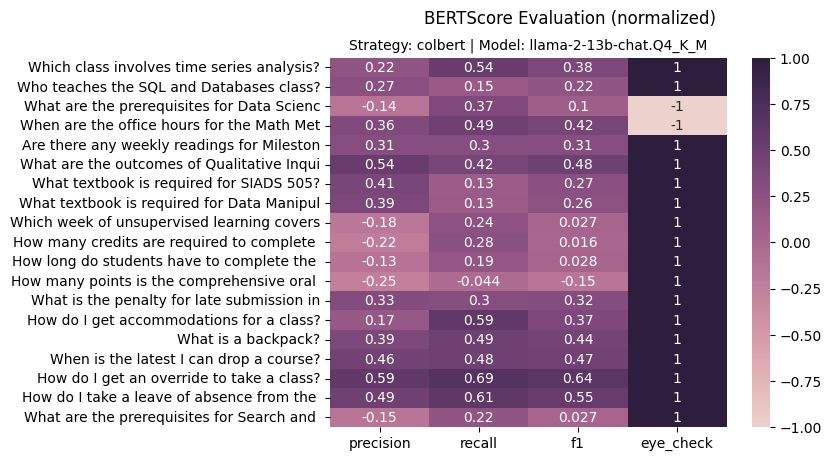

In [22]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation (normalized)")
plt.title(f"Strategy: {retrieval_strategy} | Model: {model}", fontsize=10)

plt.show()